In [1]:
import tensorflow
print(tensorflow.__version__)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


# from tensorflow.python.keras.models import Model, load_model
# from tensorflow.python.keras.layers import Dense, Input, Masking, Embedding, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed, Embedding,Masking, concatenate, Dense, Layer, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2


import os
import re
import gc

import os
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages are logged (default behavior)
                                          # 1 = INFO messages are not printed
                                          # 2 = INFO and WARNING messages are not printed
                                          # 3 = INFO, WARNING, and ERROR messages are not printed
            
# 创建一个 MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))



2024-04-04 04:48:17.222823: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2024-04-04 04:48:18.724967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 04:48:19.634704: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-04-04 04:48:19.634874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6
2024-04-04 04:48:19.635763: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 1
2024-04-04 04:48:19.635825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Create

In [2]:
# 【1083版本】
# X_data是模型输入；Y_data是模型标签
class MemoryDataGenerator(Sequence):
    def __init__(self, X_data, Y_data, batch_size):
        self.X_data = X_data
        self.Y_data = Y_data
        self.batch_size = batch_size
    
    def __len__(self):
        # 计算在给定数据集大小下的批次数量
        return int(np.ceil(len(self.X_data) / self.batch_size))
    
    def __getitem__(self, index):
        # 生成批次的数据索引
        batch_start = index * self.batch_size
        batch_end = (index + 1) * self.batch_size
        
        # 根据索引获取当前批次的数据
        batch_X = self.X_data[batch_start:batch_end]
        batch_Y = self.Y_data[batch_start:batch_end]
        
        # 对当前批次的数据进行填充
        # 现在感觉并不需要
        # batch_X_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(batch_X, padding="post", value=special_value, dtype='float32')
        
        # batch_Y_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(batch_Y, padding="post", value=special_value, dtype='float32')
        
        return np.array(batch_X), np.array(batch_Y)
        # 目的: 确保数据以适合模型处理的格式（如float32）被送入训练过程。
        # 操作: 将填充后的数据转换为NumPy数组，并确保数据类型为float32，这是大多数深度学习框架进行计算的首选格式。

In [3]:
def loading_data(folder):

    # use regular expression to filter files
    # file's name start with 'ML'
    check_name = re.compile('^ML')

    datasets = []

    # due to different operating system has different way in keeping files, here I would like to read files in sorted by name order and say it explicitly
    # the reason why must sorted by name will be explained later
    for filename in sorted(os.listdir(folder)):

        files = os.path.join(folder, filename)

        # check whether the name match the regular expression and actually is a file
        # 对文件名进行顺序排序，这对于数据保持时间顺序至关重要
        if re.match(check_name, filename) and os.path.isfile(files):

            # using pandas to read csv file
            # there are only three headers: Speed, Steering_angle, LiDAR_scan. 
            # But there are 1083 columns data, which means the number of header doesn't match number of column
            # So, we need to skip first row, and set header is None.
            # Besides, the value in last column is all None, we have to drop column at index -1
            temp = pd.read_csv(files, skiprows=1, header=None).iloc[:, :-1]

            # Because the speed is a very large number compare to steering angle,
            # We have to normalize it into [-1, 1], and do the same to steering angle
            # When apply the model in the simulator, remember to product corresponding value to the output of the model
            # index 0 is speed, index 1 is steering angle
            temp[0] = temp[0].map(lambda t : t/16.0)
            temp[1] = temp[1].map(lambda t : t/0.192)

            # append this csv file to the result, and turn it into numpy array with float format
            datasets.append(np.array(temp, dtype=float))

    # when append data to a list, there will be a copy of old list, which took a lot of memory
    # but there is no reference to them, so we can call the garbage collector
    gc.collect()

    # datasets is a 3D list, shape 0 is number of csv files, shape 1 is number of rows in that csv file, shape 2 is 1083
    return datasets

In [4]:
def loading_speed_steering_data(folder):

    # file's name start with 'car_state_blue'
    check_name = re.compile('^car_state_blue')

    datasets = []

    # Also need to iterate in sorted by name order
    for filename in sorted(os.listdir(folder)):

        files = os.path.join(folder, filename)

        if re.match(check_name, filename) and os.path.isfile(files):

            # We need another two columns from car_state_blue files,
            # one is Velocity_X, another is Steering_angle
            datasets.append(np.array(pd.read_csv(files).iloc[:, [3, 5]], dtype=float))

    gc.collect()
    # datasets is a 3D list, shape 0 is number of csv files, shape 1 is number of rows in that csv file, shape 2 is 2
    return datasets


In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.supports_masking = True 
        #告知Keras层，mask要被传入         
        
        self.pos_encoding = self.positional_encoding(position, d_model)
        
        
        # 新增位置编码权重
        self.pos_weight = self.add_weight(name='pos_weight', shape=(1, d_model), initializer='uniform', trainable=True)
        
        
    # 位置编码主要包含两个参数：position最大位置数如1326(一次超车所用的时间数)  
    # d_model时间特征的维度(每个时间点 所包含信息的长度 如1083)

    #在 get_angles 方法中，为每个时间步的每个特征维度计算一个角度值。   
    
#     老方法！！！！
#     def get_angles(self, position, i, d_model):
#         # 计算一个超车实例中，时间点i位置的角度
#         angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
#         return position * angles # position是时间步索引，代表目前所处时间点，；angels基于时间步位置和特征维度索引计算出的角度值
    
        # 序列中的每个时间步生成一个独特的角度值。这个角度值随着时间步的位置和特征维度的索引而变化，从而为每个时间步的每个特征维度生成唯一的编码。
        # 这些角度值随后被用来生成正弦和余弦位置编码，这些编码最终被加到模型的输入特征上。
        
    
    
#     新方法！！！！ 减小对以往时间步长的关注，而是更关注最近的时间步长，增大20000这个值
    def get_angles(self, position, i, d_model):
        # 修改基数，增大频率变化的缓慢度
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    
    # 输入数据中的每个时间步（例如，在一个超车实例中的每个独立的测量点）都将获得一个唯一的位置编码。  //这些位置编码是通过在每个特征维度上应用正弦和余弦函数的不同频率来生成的。
    # 对于给定的时间步，您的每个特征（在您的案例中为1083个特征，包括LiDAR数据、速度和转向角）都会根据其维度索引获得不同的角度值。
    # 生成的位置编码随后被添加到原始输入特征中。这意味着，原始的特征集（每个时间步的1083个特征）现在被增强了额外的信息，表明了每个特征在序列中的位置。
    
    def positional_encoding(self, position, d_model):
        # 生成位置编码
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 将 sin 应用于数组中的偶数索引
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 将 cos 应用于数组中的奇数索引
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    """
    对于偶数索引的维度（例如，0, 2, 4, ...），应用正弦函数。
    对于奇数索引的维度（例如，1, 3, 5, ...），应用余弦函数。
    这样做的目的是在不同的维度间提供变化，使得位置编码更加丰富和多样化。
    合并正弦和余弦编码:

    正弦和余弦值被合并为一个完整的位置编码矩阵。这个矩阵的形状将是 [1, N, d_model]，其中 N 是时间步的数量，d_model 是特征维度的数量。
    添加到输入特征:

    这个位置编码矩阵随后在模型的 call 方法中被加到输入特征上。这意味着每个时间步的每个特征都会得到一个唯一的位置编码，从而使模型能够识别输入数据中时间步的顺序。       
    """

    def call(self, inputs):
        # 将位置编码添加到输入中
        # return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
        
        
        # 使用权重调节位置编码的影响
        weighted_pos_encoding = self.pos_encoding * self.pos_weight
        return inputs + weighted_pos_encoding[:, :tf.shape(inputs)[1], :]


In [6]:
def load_data_from_folders(folders):
    all_datasets = []  # 这里假设所有数据集的数据将被合并到一个单一的列表中
    all_speed_steering = []  # 同上，对于速度和转向数据
    
    for folder in folders:
        # 加载当前文件夹的数据
        datasets = loading_data(folder)
        speed_steering = loading_speed_steering_data(folder)
        
        # 假设datasets和speed_steering是列表形式的数据，我们可以扩展现有列表以包含新加载的数据
        all_datasets.extend(datasets)  # 扩展而不是附加以保持列表元素的平坦
        all_speed_steering.extend(speed_steering)
    
    return all_datasets, all_speed_steering

# 使用示例
# folders = ["/root/autodl-tmp/Dataset_shanghai", "/root/autodl-tmp/Australia_dataset", "/root/autodl-tmp/Gulf_dataset", "/root/autodl-tmp/Malaysian_dataset"]
folders = ["/root/autodl-tmp/Dataset_shanghai"]
datasets, speed_steering = load_data_from_folders(folders)
folders2 = ["/root/autodl-tmp/Gulf_dataset"]
datasets_test, speed_steering_test = load_data_from_folders(folders2)

In [7]:
from tensorflow.keras.layers import Dense, Layer

class LocalMultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model, window_size, rate=0.1):
        super(LocalMultiHeadAttention, self).__init__()
        self.supports_masking = True
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        self.window_size = window_size

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)
        self.dropout = Dropout(rate)

    def split_heads(self, x):
        x = tf.reshape(x, (tf.shape(x)[0], -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q))
        k = self.split_heads(self.wk(k))
        v = self.split_heads(self.wv(v))

        # Initialize tensor array for storing attention scores per head
        attention_scores = tf.TensorArray(dtype=tf.float32, size=self.num_heads)
        if mask is not None:
            # 将mask扩展到4D以匹配scaled_attention_logits的形状

            # 假设mask原始形状为 [batch_size, seq_len]
            mask = tf.cast(mask, dtype=bool)
            # 扩展掩码以适应scaled_attention_logits的形状
            mask = mask[:, tf.newaxis, :]  # 现在形状为 [batch_size, 1, seq_len]
       
        for i in range(self.num_heads):
            # Calculate scaled dot-product attention with window masking for each head
            depth = tf.cast(tf.shape(k)[3], tf.float32)
            q_head = q[:, i, :, :]
            k_head = k[:, i, :, :]
            v_head = v[:, i, :, :]

            matmul_qk = tf.matmul(q_head, k_head, transpose_b=True)
            scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)
            
            if mask is not None:
                # 将mask扩展到4D以匹配scaled_attention_logits的形状

                # 尝试应用掩码
                # 注意：这里仅为示例，实际操作可能需要根据上下文调整
                scaled_attention_logits = tf.where(mask, scaled_attention_logits, tf.fill(tf.shape(scaled_attention_logits), -1e9))

            

            # Softmax is applied to axis=-1 so that the scores sum to 1.
            attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
            attention_weights = self.dropout(attention_weights)

            # Output of a single head
            output_head = tf.matmul(attention_weights, v_head)
            # 示例：验证输出头部和堆叠后的张量形状
            attention_scores = attention_scores.write(i, output_head)
            stacked_attention_scores = attention_scores.stack()

        attention_scores = attention_scores.stack()
        attention_scores = tf.transpose(attention_scores, perm=[1, 2, 0, 3])
        
        
        # Concatenate heads and pass through final linear layer
        concat_attention = tf.reshape(attention_scores, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output
    




In [8]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, dff, d_model, rate, window_size):
        super(TransformerEncoder, self).__init__()
        self.supports_masking = True
#         太重要了，确保mask被传入！
        self.mha = LocalMultiHeadAttention(num_heads=num_heads, d_model=d_model, window_size=window_size, rate=rate)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=l2(1e-4)),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(d_model, kernel_regularizer=l2(1e-4))
        ])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2


In [9]:
# if you want to use part of the data, feel free to add bracket after datasets and speed_steering, like [0:100], make sure the size of sub data matches
new_datasets = datasets
new_speed_steering = speed_steering
new_datasets_test = datasets_test
new_speed_steering_test = speed_steering_test



In [10]:
special_value = -100

In [11]:
# 【1083版本】

X = []
Y = []

X_test = []
Y_test = []


for data, speed_steering in zip(new_datasets, new_speed_steering):
    # 将LiDAR数据（除了前两列外的所有列）和速度、转向角数据（从new_speed_steering）合并
    current_features = np.concatenate((data[:, 2:], speed_steering), axis=1)
    X.append(current_features)

    # 使用前两列作为要预测的目标
    Y.append(data[:, 0:2])
    
for data, speed_steering in zip(new_datasets_test, new_speed_steering_test):
    # 将LiDAR数据（除了前两列外的所有列）和速度、转向角数据（从new_speed_steering）合并
    X_test.append(data[:, 2:])
    # 使用前两列作为要预测的目标
    Y_test.append(data[:, 0:2])
    # current_features = np.concatenate((data[:, 2:], speed_steering), axis=1)
    # X_combined.append(current_features)


- 下一步就是确定这个X可不可以放到Transformer中，可能还要加上时间戳或者什么 确保能分别开
- 再一个就是我还不清楚现在的XY分别张什么样子，需要打印出来看一下


- X列表，有193个数组，这代表着上海赛道数据集的193次超车实例 / 每一个数组都是二维数组，一个数组有一行 
- 一行中有（1326 ... 739 取决于这个超车实例所用的时间）个子数组 
- 每个子数组代表着超车过程中的一个时间节点，里面包含了该时间节点我们控制的超车车辆-小蓝车的手柄端速度信息，转向角信息，雷达信息；

In [12]:
# 【1083版本】
# 示例：选择和处理较短的序列 进行模型测试

# # 截断长度大于4000的序列
X_trimmed = [x if len(x) <= 4000 else x[:4000] for x in X]
Y_trimmed = [y if len(y) <= 4000 else y[:4000] for y in Y]

# # 填充至最大长度
Xpad = tensorflow.keras.preprocessing.sequence.pad_sequences(X_trimmed, padding='post', value=special_value)
Ypad = tensorflow.keras.preprocessing.sequence.pad_sequences(Y_trimmed, padding='post', value=special_value)

# # 截断长度大于4000的序列
X_test_trimmed = [x if len(x) <= 4000 else x[:4000] for x in X_test]
Y_test_trimmed = [y if len(y) <= 4000 else y[:4000] for y in Y_test]
# X_combined_trimmed = [z if len(z) <= 4000 else z[:4000] for z in X_combined]

# # 填充至最大长度
Xpad_test = tensorflow.keras.preprocessing.sequence.pad_sequences(X_test_trimmed, padding='post', value=special_value)
Ypad_test = tensorflow.keras.preprocessing.sequence.pad_sequences(Y_test_trimmed, padding='post', value=special_value)


In [13]:
feature_size = 1083
num_heads = 3
# 一个head就有100m左右，是影响模型大小的最重要的参数
dff = 2048
num_layers = 6
dropout_rate = 0.15
window_size = 80
# 这个也影响文件大小


# 【1083版本】
# 定义模型输入
with strategy.scope():
    # inputs = tf.keras.Input(shape=(None, feature_size))
    inputs = Input(shape=(None, feature_size))

    # 添加 Masking 层
    masking_layer = Masking(mask_value=special_value)
    x = masking_layer(inputs)

    # pos_encoding_layer = PositionalEncoding(position=4000, d_model=feature_size_after_conv)
    pos_encoding_layer = PositionalEncoding(position=4000, d_model=feature_size)
    x = pos_encoding_layer(x)

    # 添加 Transformer 编码器层
    for _ in range(num_layers):
        # x = TransformerEncoder(num_heads=num_heads, dff=dff, d_model=feature_size_after_conv, rate=dropout_rate)(x)
        x = TransformerEncoder(num_heads=num_heads, dff=dff, d_model=feature_size, window_size=window_size, rate=dropout_rate)(x)

    # 添加输出层
    outputs = Dense(2, activation='linear')(x)
    
    
    # 创建模型
    model = Model(inputs=inputs, outputs=outputs)

    
    # 定义模型
    # model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1083)]      0         
                                                                 
 masking (Masking)           (None, None, 1083)        0         
                                                                 
 positional_encoding (Positi  (None, None, 1083)       1083      
 onalEncoding)                                                   
                                                                 
 transformer_encoder (Transf  (None, None, 1083)       9139319   
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  (None, None, 1083)       9139319   
 sformerEncoder)                                                 
                                                             

In [14]:
del datasets
del speed_steering 
gc.collect()


11706

In [15]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [16]:
train_generator = MemoryDataGenerator(Xpad, Ypad, batch_size=4)

# train_generator_test = MemoryDataGenerator(Xpad_test, Ypad_test, batch_size=1)

# 训练模型
history = model.fit(
    train_generator,
    epochs=30,  # 举例
    # batch_size=8,  # 举例
    validation_data=(Xpad,Ypad)
)


2024-04-04 04:49:43.651861: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_4424"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1


Epoch 1/30
INFO:tensorflow:batch_all_reduce: 99 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 99 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

2024-04-04 04:50:04.037357: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - ETA: 0s - loss: 10.3264 - mae: 1.5456

2024-04-04 04:50:27.887147: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_35643"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:32"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

49/49 [==============================] - 56s 724ms/step - loss: 10.3264 - mae: 1.5456 - val_loss: 1.7595 - val_mae: 0.1553
Epoch 2/30
49/49 [==============================] - 27s 552ms/step - loss: 1.8066 - mae: 0.4008 - val_loss: 1.6752 - val_mae: 0.1539
Epoch 3/30
49/49 [==============================] - 27s 554ms/step - loss: 1.7196 - mae: 0.3846 - val_loss: 1.6000 - val_mae: 0.1281
Epoch 4/30
49/49 [==============================] - 27s 554ms/step - loss: 1.6400 - mae: 0.3697 - val_loss: 1.5314 - val_mae: 0.1215
Epoch 5/30
49/49 [==============================] - 27s 551ms/step - loss: 1.5646 - mae: 0.3509 - val_loss: 1.4679 - val_mae: 0.1218
Epoch 6/30
49/49 [==============================] - 27s 554ms/step - loss: 1.4936 - mae: 0.3308 - val_loss: 1.4094 - val_mae: 0.1403
Epoch 7/30
49/49 [==============================] - 27s 555ms/step - loss: 1.4284 - mae: 0.3123 - val_loss: 1.3566 - val_mae: 0.1126
Epoch 8/30
49/49 [==============================] - 27s 557ms/step - loss: 1.36

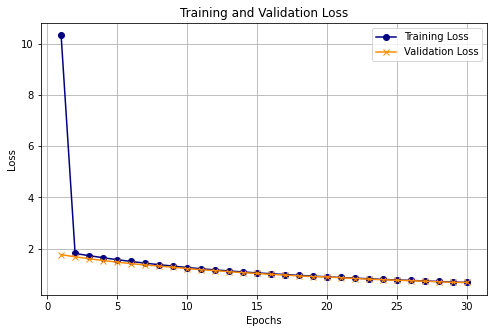

In [26]:
import matplotlib.pyplot as plt
import os

# 假定 history 对象中包含了训练和验证的损失以及MAE
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

# 绘制损失曲线并保存
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'navy', label='Training Loss', marker='o')
plt.plot(epochs, val_loss, 'darkorange', label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # 添加网格线

# 定义损失图像保存路径
# save_path_loss = '/root/autodl-tmp/models/image/Transformer_model_loss.png'

save_path_loss = '/root/autodl-tmp/models/计算时间和资源实验/4.Transformer_局部注意力_不处理雷达/Transformer_model_loss.png'
# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(os.path.dirname(save_path_loss)):
    os.makedirs(os.path.dirname(save_path_loss))
# 保存图形到文件，设置保存时的背景色
plt.savefig(save_path_loss, dpi=300, bbox_inches='tight', facecolor='white')


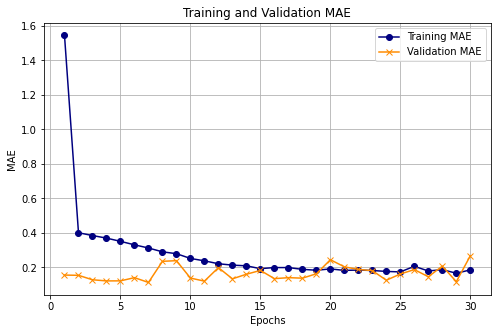

In [22]:
# 绘制MAE曲线并保存
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_mae, 'navy', label='Training MAE', marker='o')
plt.plot(epochs, val_mae, 'darkorange', label='Validation MAE', marker='x')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)  # 添加网格线

# 定义MAE图像保存路径
# save_path_mae = '/root/autodl-tmp/models/image/Transformer_model_mae.png'
save_path_mae = '/root/autodl-tmp/models/计算时间和资源实验/4.Transformer_局部注意力_不处理雷达/Transformer_model_mae.png'
# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(os.path.dirname(save_path_mae)):
    os.makedirs(os.path.dirname(save_path_mae))
# 保存图形到文件，设置保存时的背景色
plt.savefig(save_path_mae, dpi=300, bbox_inches='tight', facecolor='white')


In [24]:
# model.save("/root/autodl-tmp/models/Transformer_model/调整记忆区间——加解码器层数——model/")

model.save("/root/autodl-tmp/models/计算时间和资源实验/4.Transformer_局部注意力_不处理雷达/")

INFO:tensorflow:Assets written to: /root/autodl-tmp/models/计算时间和资源实验/4.Transformer_局部注意力_不处理雷达/assets


INFO:tensorflow:Assets written to: /root/autodl-tmp/models/计算时间和资源实验/4.Transformer_局部注意力_不处理雷达/assets
/root/miniconda3/lib/python3.8/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/root/miniconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [20]:
# model = load_model("/root/autodl-tmp/models/Transformer_model/12_short_sequence/")
# model.summary()